Changes:

* Subsetting to genes that are present in all data sources.. array, RNA-seq, and TEMPUS. 10363 genes.
* Subsetting the JIVE gene signatures to those present genes.

Questions: Are there missing genes, in array, that are present in RNA-seq, that would be better to have for TEMPUS?




In [1]:
#devtools::install_github("gibbsdavidl/robencla", force = T)


── R CMD build ──────────────────────────────────────────────────────────────────────────────────────────────────────────────
✔  checking for file ‘/tmp/Rtmpu5C6kH/remotes95d1e498af11/Gibbsdavidl-robencla-044a433/DESCRIPTION’
─  preparing ‘robencla’:
✔  checking DESCRIPTION meta-information
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
─  building ‘robencla_0.2.0.tar.gz’
   


Installing package into ‘/home/daveg/R/x86_64-pc-linux-gnu-library/4.2’
(as ‘lib’ is unspecified)



In [99]:
library(tidyverse)
library(robencla)

In [100]:
dat.m <- read_csv('data/Males_Array_Data_CW.csv')
load("data/Males_feature_sel_genelist.rda")
# removing signature genes that are not available in our data sets
male.jive.gene.list <- readRDS("data/Males_jive_cluster_genes_CW.rds") %>% dplyr::filter(value %in% colnames(dat.m))

Rows: 220 Columns: 10356
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr     (2): sample, cluster.group
dbl (10354): PDIA2, ZNF195, PIK3C2B, PHB2, SERF2, PLEKHG6, HOXA9, CD2AP, AP3...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [101]:
table(dat.m$cluster.group)


cluster1 cluster2 cluster3 cluster4 cluster5 
      38       85       35       26       36 

In [102]:
genelist

[1] "NTRK2"    "POSTN"    "TMEM43"   "JAG1"     "POSTN"    "MAN1C1"  
 [7] "CIT"      "POLR1B"   "HSPB8"    "POSTN"    "MID1IP1"  "ZCCHC10" 
[13] "BBOX1"    "RCAN1"    "TMEM43"   "JAG1"     "IBSP"     "PPARGC1A"
[19] "CIT"      "POLR1B"   "TPM4"     "C1D"      "MID1IP1"  "ZCCHC10" 
[25] "TPM4"     "IFI44L"   "TMEM43"   "JAG1"     "METTL3"   "IFI44L"  
[31] "CIT"      "POLR1B"   "RSAD2"    "GSK3A"    "MID1IP1"  "ZCCHC10" 
[37] "DNAJC7"   "PRKRIP1"  "TMEM43"   "JAG1"     "MAP3K7"   "ZNF512B" 
[43] "CIT"      "POLR1B"   "DNAJC7"   "LARS2"    "MID1IP1"  "ZCCHC10" 
[49] "NDC80"    "CRYM"     "TMEM43"   "JAG1"     "CRYM"     "KIF20A"  
[55] "CIT"      "POLR1B"   "CCK"      "TTK"      "MID1IP1"  "ZCCHC10"

In [103]:
dim(dat.m)

[1]   220 10356

In [104]:
genelist_m <- genelist

sigs.m <- list("C1"=male.jive.gene.list$value[male.jive.gene.list$cluster.group == 'cluster1'],
               "C2"=male.jive.gene.list$value[male.jive.gene.list$cluster.group == 'cluster2'],
               "C3"=male.jive.gene.list$value[male.jive.gene.list$cluster.group == 'cluster3'],
               "C4"=male.jive.gene.list$value[male.jive.gene.list$cluster.group == 'cluster4'],
               "C5"=male.jive.gene.list$value[male.jive.gene.list$cluster.group == 'cluster5']
)

# our classifier object named Anne.
anne <- Robencla$new("Anne")

# xgboost parameters to pass to each sub-classifier in the ensembles
params <- list(max_depth=12,    # "height" of the tree, 6 is actually default. I think about 12 seems better.  (xgboost parameter)
               eta=0.2,        # this is the learning rate. smaller values slow it down, more conservative   (xgboost parameter)
               nrounds=24,     # number of rounds of training, lower numbers less overfitting (potentially)  (xgboost parameter)
               nthreads=4,     # parallel threads
               gamma=0.2,        # Minimum loss reduction required to again partition a leaf node. higher number ~ more conservative (xgboost parameter)
               lambda=1.2,     # L2 regularization term on weights, higher number ~ more conservative (xgboost parameter)
               alpha=0.2,     # L1 regularization term on weights. higher number ~ more conservative (xgboost parameter)
               verbose=0,
               train_perc=0.8,
               combine_function='median',
               size=11
)

In [ ]:
# First we use the training data
anne$autocv(data_frame=dat.m,
            label_name='cluster_group',
            sample_id = 'sample',
            data_mode=c('pairs','quartiles'), # pairs,allpairs,sigpairs,quartiles,tertiles,binarize,ranks,original #
            signatures=NULL,
            pair_list=genelist,  # subset to these genes.
            params=params,
            cv_rounds=10
            )


In [ ]:
df.m <- anne$cv_results
df.m$cluster1 <- as.numeric(df.m$cluster1)
df.m$cluster2 <- as.numeric(df.m$cluster2)
df.m$cluster3 <- as.numeric(df.m$cluster3)
df.m$cluster4 <- as.numeric(df.m$cluster4)
df.m$cluster5 <- as.numeric(df.m$cluster5)
head(df.m)

write.table(as.data.frame(df.m), 'results/male_cv_pairs.csv', sep=',', quote = F, row.names = F)

In [39]:
table(Pred=df.m$BestCalls, True=df.m$Label)

          True
Pred       cluster1 cluster2 cluster3 cluster4 cluster5
  cluster1       30        2        1        1        0
  cluster2        5       83        2        1        1
  cluster3        0        0       22        2        5
  cluster4        1        0        4       18        2
  cluster5        2        0        6        4       28

In [40]:
anne$classification_metrics()

,Label,Accuracy,Sensitivity,Specificity,Precision,F1
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
cluster1,cluster1,0.8227273,0.7894737,0.9780220,0.8823529,0.8333333
cluster2,cluster2,0.8227273,0.9764706,0.9333333,0.9021739,0.9378531
cluster3,cluster3,0.8227273,0.6285714,0.9621622,0.7586207,0.6875000
cluster4,cluster4,0.8227273,0.6923077,0.9639175,0.7200000,0.7058824
cluster5,cluster5,0.8227273,0.7777778,0.9347826,0.7000000,0.7368421
Average,Average,0.8227273,0.7729202,0.9544435,0.7926295,0.7802822


In [98]:

imp_list <- anne$importance()

save(imp_list, file='results/male_CV_pairs_importance.rda')

imp_list

Feature,MedGain,MedCover,MedFreq
<chr>,<dbl>,<dbl>,<dbl>
RSAD2_X_GSK3A,0.207175767,0.178657550,0.14678899
TPM4_X_IFI44L,0.199726871,0.185590135,0.09433962
HSPB8_X_POSTN,0.138631966,0.125638374,0.11566858
NTRK2_X_POSTN,0.124495269,0.081786569,0.08450890
METTL3_X_IFI44L,0.122918621,0.163861831,0.09401709
CCK_X_TTK,0.030084274,0.039510264,0.09174312
NDC80_X_CRYM,0.026501951,0.052381966,0.08910891
MAP3K7_X_ZNF512B,0.025710974,0.043205437,0.07547170
CRYM_X_KIF20A,0.013737878,0.018353812,0.04716981


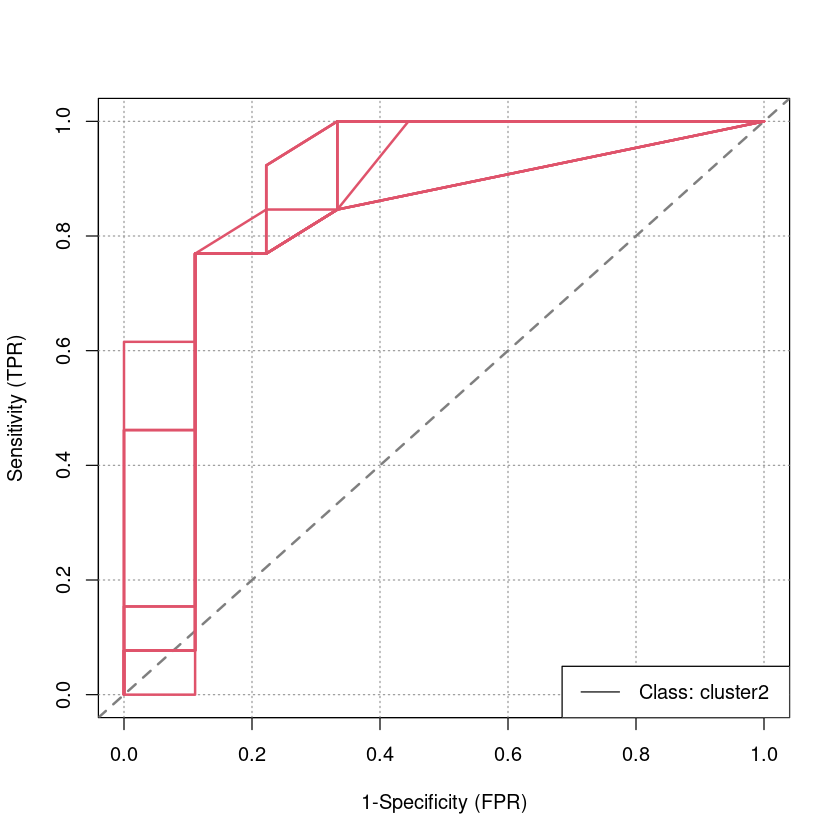

In [77]:
#ensemble_rocs(anne)
plot_roc(anne, 1, flip=T)

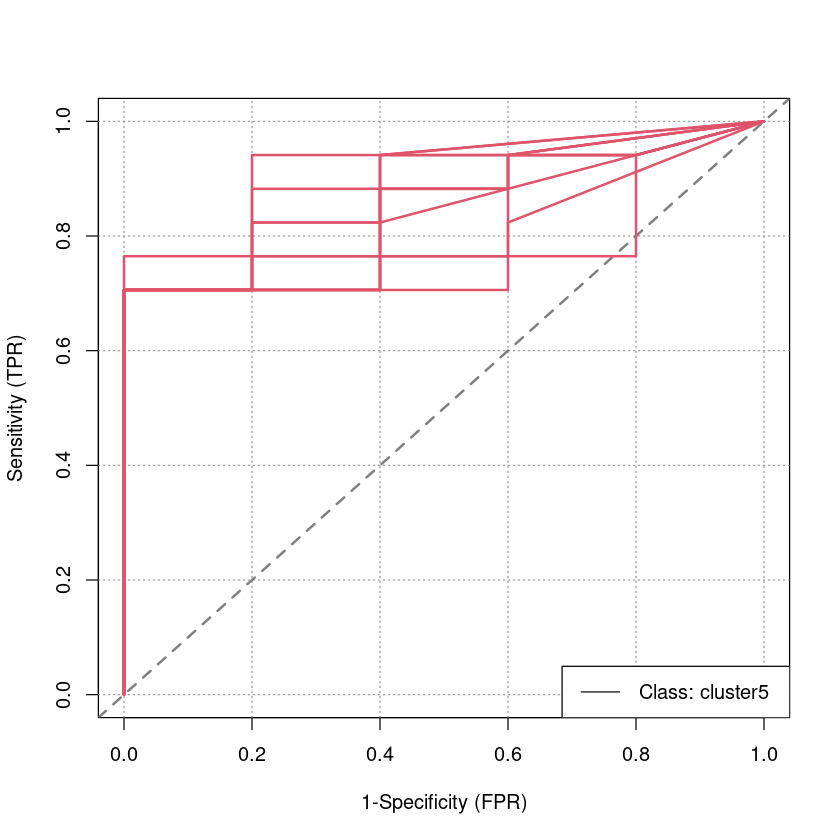

In [78]:
#ensemble_rocs(anne)
plot_roc(anne, 2, flip=T)

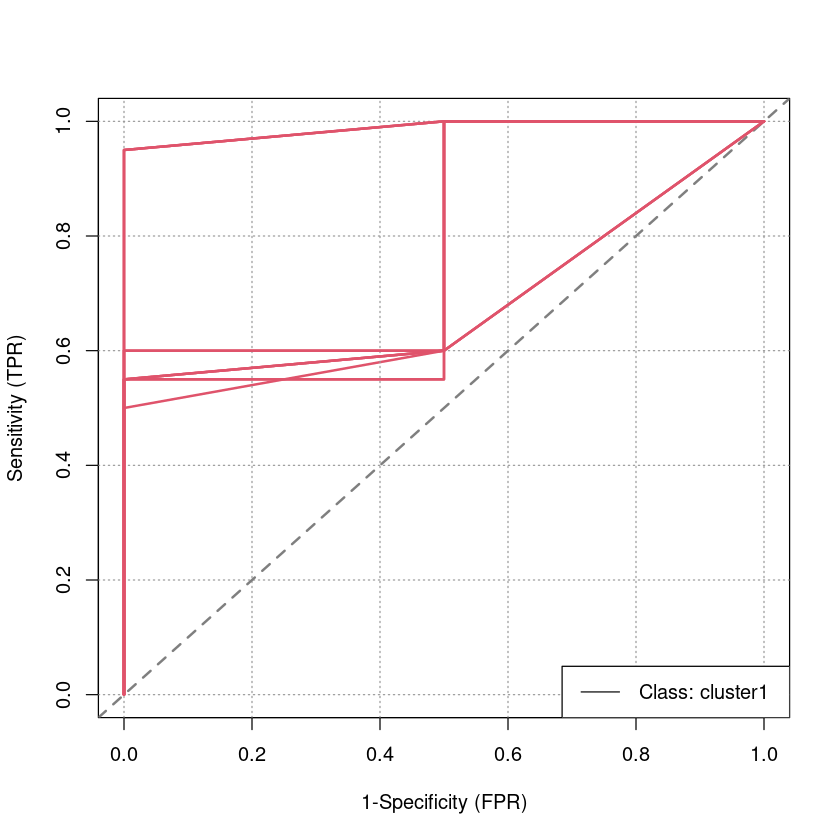

In [79]:
#ensemble_rocs(anne)
plot_roc(anne, 3, flip=T)

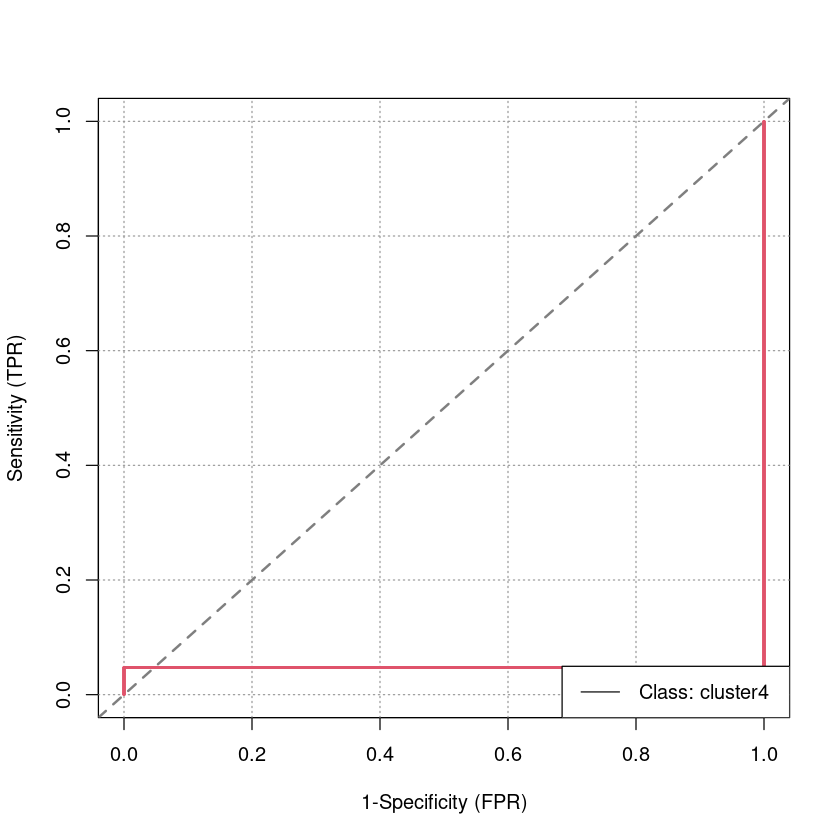

In [80]:
#ensemble_rocs(anne)
plot_roc(anne, 4, flip=T)

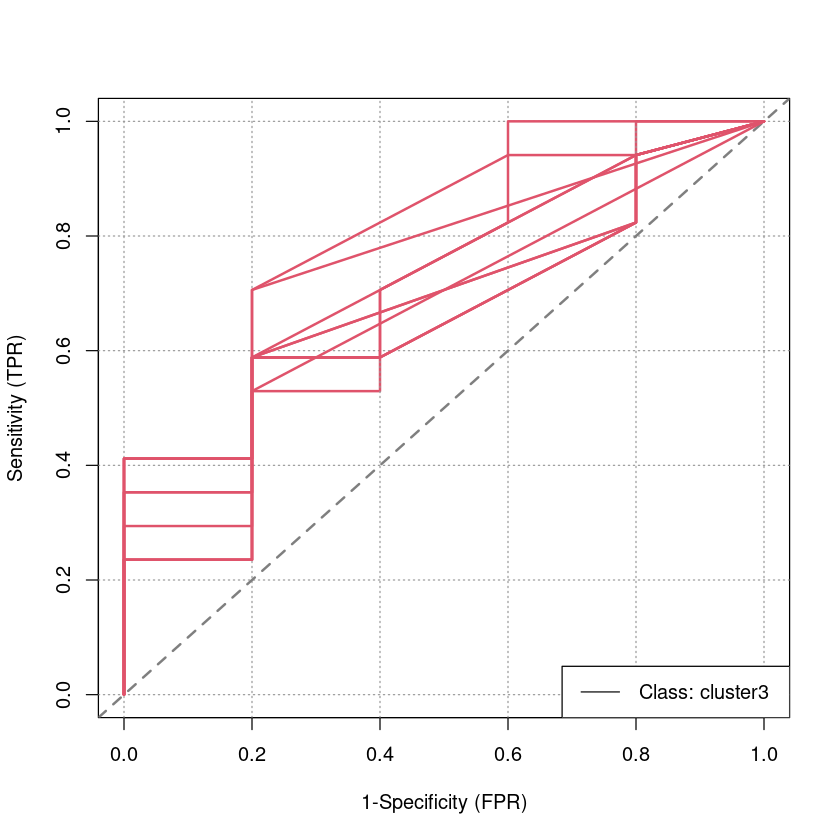

In [81]:
#ensemble_rocs(anne)
plot_roc(anne, 5, flip=T)

In [ ]:
### FEMALES ###

In [64]:
dat.f <- read_csv('data/Females_Array_Data_CW.csv')
load('data/Females_feature_sel_genelist.rda')
genelist_f <- genelist
# removing signature genes that are not available in our data sets
female.jive.gene.list <- readRDS("data/Female_jive_cluster_genes_CW.rds") %>% dplyr::filter(value %in% colnames(dat.f))

Rows: 140 Columns: 10356
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr     (2): sample, cluster.group
dbl (10354): PDIA2, ZNF195, PIK3C2B, PHB2, SERF2, PLEKHG6, HOXA9, CD2AP, AP3...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [69]:
table(dat.f$cluster.group)


cluster1 cluster2 cluster3 cluster4 cluster5 
      41       24       14       21       40 

In [70]:
length(genelist)

[1] 60

In [71]:
genelist_f <- genelist

sigs_f <- list("C1"=female.jive.gene.list$value[female.jive.gene.list$cluster.group == 'cluster1'],
               "C2"=female.jive.gene.list$value[female.jive.gene.list$cluster.group == 'cluster2'],
               "C3"=female.jive.gene.list$value[female.jive.gene.list$cluster.group == 'cluster3'],
               "C4"=female.jive.gene.list$value[female.jive.gene.list$cluster.group == 'cluster4'],
               "C5"=female.jive.gene.list$value[female.jive.gene.list$cluster.group == 'cluster5']
)


# our classifier object named Roberta
buffy <- Robencla$new("buffy")

# xgboost parameters to pass to each sub-classifier in the ensembles
params <- list(max_depth=12,    # "height" of the tree, 6 is actually default. I think about 12 seems better.  (xgboost parameter)
               eta=0.2,        # this is the learning rate. smaller values slow it down, more conservative   (xgboost parameter)
               nrounds=24,     # number of rounds of training, lower numbers less overfitting (potentially)  (xgboost parameter)
               nthreads=4,     # parallel threads
               gamma=0.2,        # Minimum loss reduction required to again partition a leaf node. higher number ~ more conservative (xgboost parameter)
               lambda=1.2,     # L2 regularization term on weights, higher number ~ more conservative (xgboost parameter)
               alpha=0.2,     # L1 regularization term on weights. higher number ~ more conservative (xgboost parameter)
               verbose=0,
               train_perc=0.8,
               combine_function='median',
               size=11
)

In [72]:

# First we use the training data
buffy$autocv(data_file='data/Females_Array_Data_CW.csv',
               label_name='cluster.group',
               sample_id = 'sample',
               data_mode=c('pairs'), # pairs,sigpairs,quartiles,tertiles,binarize,ranks,original #
               signatures=NULL,
               pair_list=genelist_f,  # subset to these genes.
               params=params,
               cv_rounds=10
              )



[1] "*** Training-Testing Round 1 ***"
[1] "*** Training-Testing Round 2 ***"
[1] "*** Training-Testing Round 3 ***"
[1] "*** Training-Testing Round 4 ***"
[1] "*** Training-Testing Round 5 ***"
[1] "*** Training-Testing Round 6 ***"
[1] "*** Training-Testing Round 7 ***"
[1] "*** Training-Testing Round 8 ***"
[1] "*** Training-Testing Round 9 ***"
[1] "*** Training-Testing Round 10 ***"


In [73]:
df.f <- buffy$cv_results
df.f$cluster1 <- as.numeric(df.f$cluster1)
df.f$cluster2 <- as.numeric(df.f$cluster2)
df.f$cluster3 <- as.numeric(df.f$cluster3)
df.f$cluster4 <- as.numeric(df.f$cluster4)
df.f$cluster5 <- as.numeric(df.f$cluster5)
head(df.f)

write.table(as.data.frame(df.f), 'results/female_cv_pairs.csv', sep=',', quote = F, row.names = F)

,SampleIDs,BestCalls,cluster5,cluster2,cluster1,cluster3,cluster4,Label
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
TCGA-08-0517-01,TCGA-08-0517-01,cluster3,0.03832333,0.03762304,0.02953892,0.88142737,0.013087344,cluster3
TCGA-12-1093-01,TCGA-12-1093-01,cluster2,0.02726347,0.89981985,0.04319151,0.01203663,0.017688541,cluster2
TCGA-06-2569-01,TCGA-06-2569-01,cluster1,0.02661896,0.01656002,0.44881553,0.49890210,0.009103386,cluster1
TCGA-28-1751-01,TCGA-28-1751-01,cluster5,0.68918667,0.09591463,0.18552584,0.01338344,0.015989427,cluster5
TCGA-19-1786-01,TCGA-19-1786-01,cluster1,0.18007335,0.02871569,0.60073259,0.01295079,0.177527574,cluster1
TCGA-19-0957-01,TCGA-19-0957-01,cluster5,0.80007373,0.12334571,0.01354714,0.01805966,0.044973764,cluster5


In [74]:
table(Pred=df.f$BestCalls, True=df.f$Label)

          True
Pred       cluster1 cluster2 cluster3 cluster4 cluster5
  cluster1       37        2        0        1        0
  cluster2        0       20        0        2        1
  cluster3        0        0       12        0        0
  cluster4        0        0        1       16        0
  cluster5        4        2        1        2       39

In [76]:
buffy$classification_metrics()

,Label,Accuracy,Sensitivity,Specificity,Precision,F1
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
cluster1,cluster1,0.8857143,0.9024390,0.9696970,0.9250000,0.9135802
cluster2,cluster2,0.8857143,0.8333333,0.9741379,0.8695652,0.8510638
cluster3,cluster3,0.8857143,0.8571429,1.0000000,1.0000000,0.9230769
cluster4,cluster4,0.8857143,0.7619048,0.9915966,0.9411765,0.8421053
cluster5,cluster5,0.8857143,0.9750000,0.9100000,0.8125000,0.8863636
Average,Average,0.8857143,0.8659640,0.9690863,0.9096483,0.8832380


In [97]:

imp_list <- buffy$importance()

save(imp_list, file='results/female_CV_pairs_importance.rda')


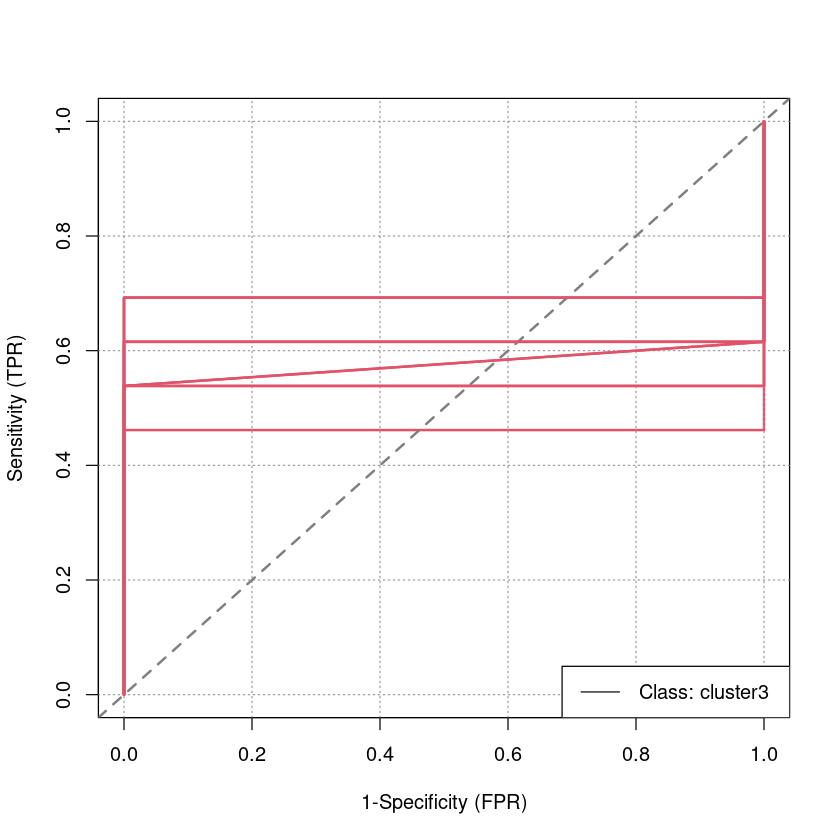

In [82]:
#ensemble_rocs(anne)
plot_roc(buffy, 1, flip=T)

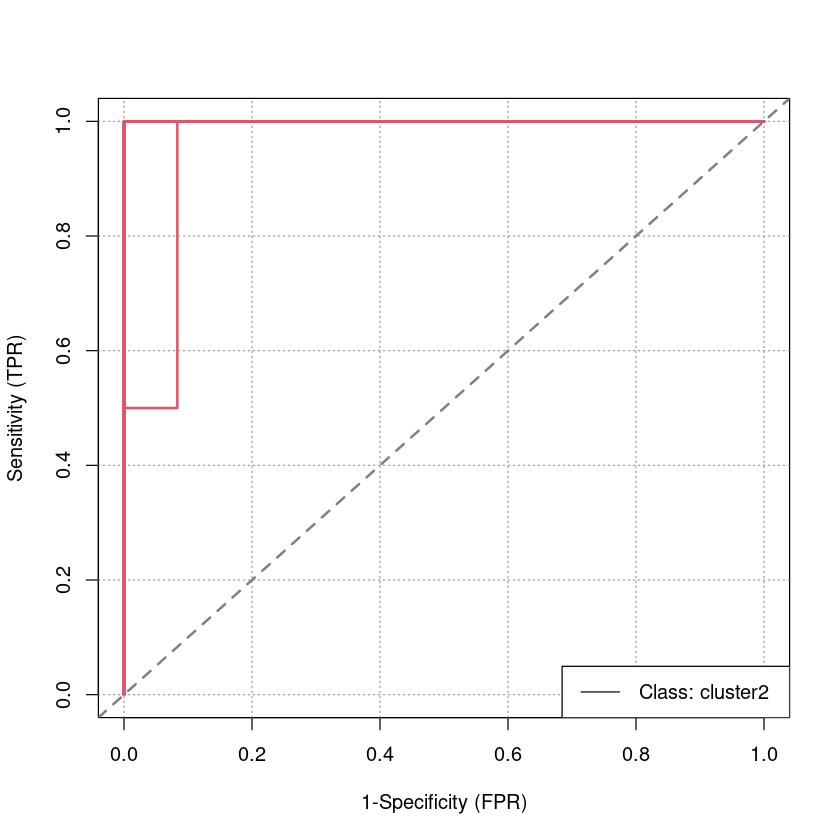

In [89]:
#ensemble_rocs(anne)
plot_roc(buffy, 2, flip=F)

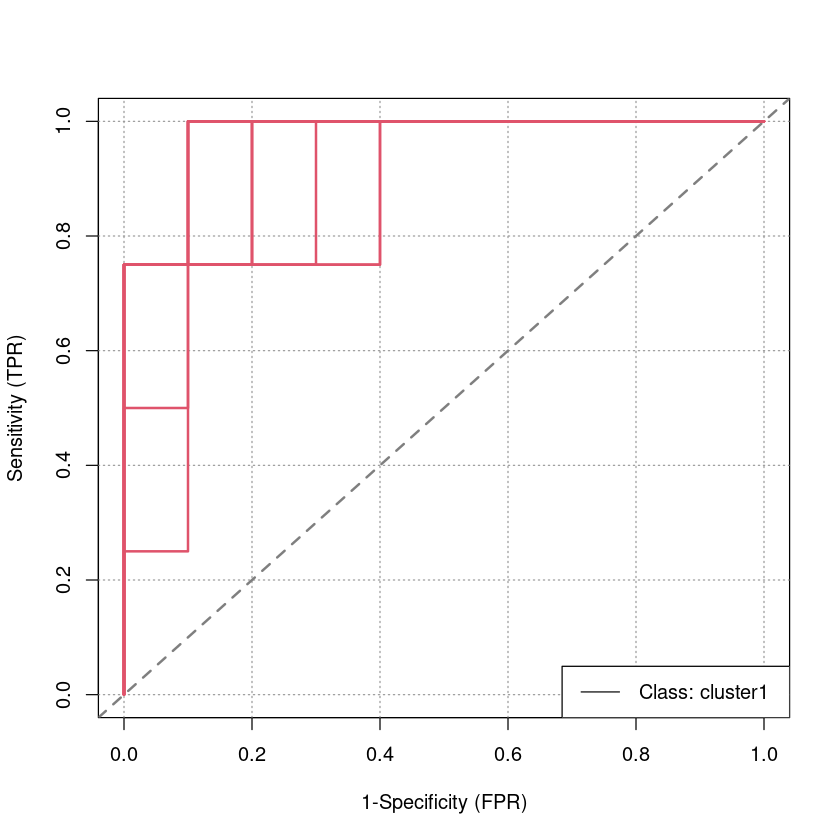

In [88]:
#ensemble_rocs(anne)
plot_roc(buffy, 3, flip=F)

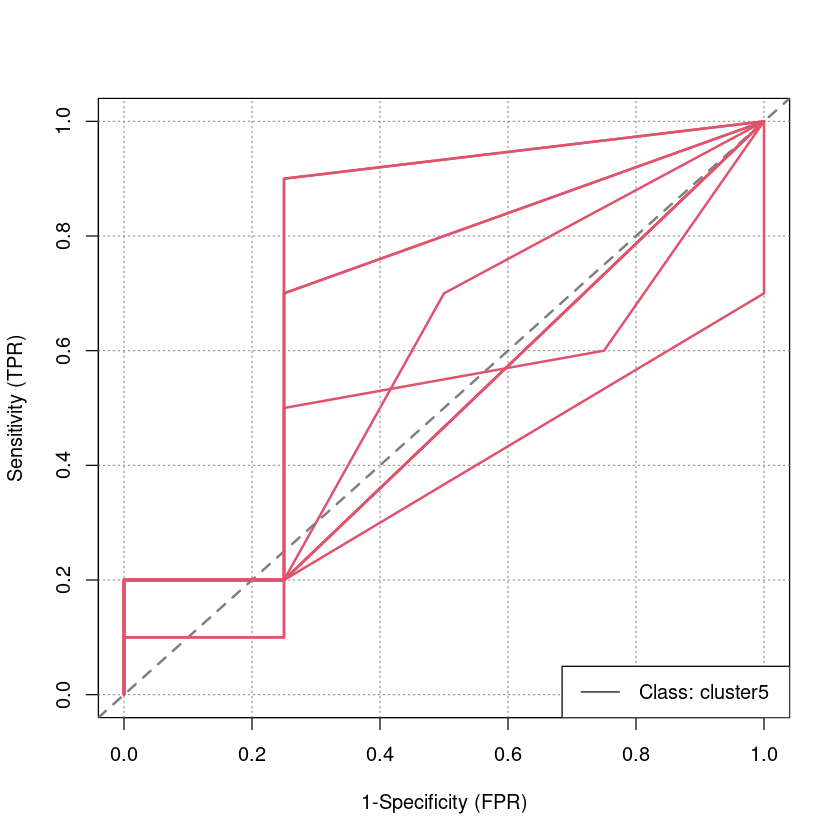

In [85]:
#ensemble_rocs(anne)
plot_roc(buffy, 4, flip=T)

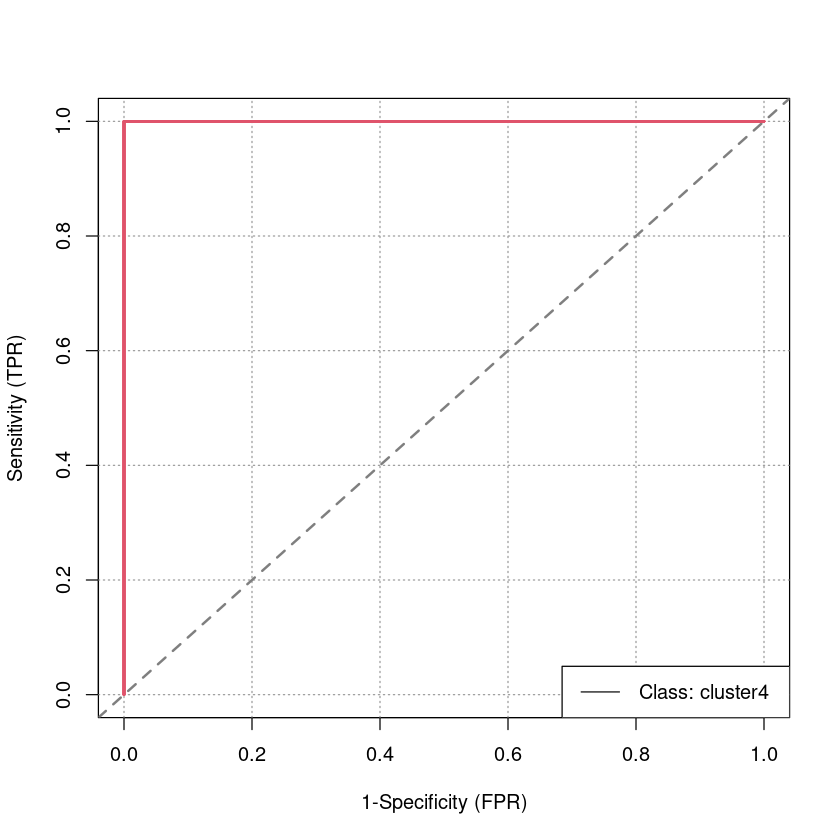

In [87]:
#ensemble_rocs(anne)
plot_roc(buffy, 5, flip=F)

In [ ]:
#FIN